# Exercise 09: Fairness Assessment and Mitgation

Welcome to the eighth exercise for Big Data Management.

Your objectives for this session are to:

- implement a `RandomForestClassifier` to predict recidivism with the COMPAS dataset,
- inspect model performance and feature importance,
- perform a fairness assessment, and
- use `ThresholdOptimizer` for post-processing unfairness mitigation.

First let's import the libraries for today.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

To perform a fairness assessment and mitigate unfairness, we'll use a library called `fairlearn`. Check out the `fairlearn` documentation [here](https://fairlearn.org/v0.9/quickstart.html).


If you haven't installed `fairlearn` in the past, uncomment the code in the next block and run the installation command before proceeding.

In [23]:
# pip install fairlearn

Once `fairlearn` is installed, use the code below to import the necessary functions from the library.

In [24]:
# for fairness assessments
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate, selection_rate, equalized_odds_difference, demographic_parity_difference, selection_rate

# for unfairness mitigation
from fairlearn.postprocessing import ThresholdOptimizer

Now let's read in our dataset. 

In [25]:
df = pd.read_csv('propublica_data_for_fairml.csv')

Today we'll be working with a preprocessed version of the COMPAS (which stands for Correctional Offender Management Profiling for Alternative Sanctions) data. In this dataset, the target variable is `Two_yr_Recidivism`: a binary class label indicating if a defendant actually re-offended within two years of their parole (1 if `yes` and 0 if `no`). As attributes, we have the number of prior offenses (`Number_of_Priors`) and various binary variables on the defendant's demographics and the nature of their past offence(s).

In [26]:
df.head()

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


You can check out the original data [here](https://github.com/propublica/compas-analysis) and an article outlining ProPublica's analysis [here](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). 

____

### Part 1: Implementing a classifier

Machine learning algorithms are increasingly adopted by judicial systems for predictive policing and recidivism prediction. In the case of Northepointe's COMPAS tool, the intention was to help U.S. judges decide whether to release defendants on parole. If a defendant is likely to re-offend, then they should not be released, and vice versa. COMPAS is a proprietary tool, which means exact details of its develop and functionality (e.g., what specific algorithm was used) are not publicly disclosed. 

Let's implement our own classifier. Use the code below to define your feature matrix `X` and target variable `y`, and then make a train-test split.

In [27]:
# define the feature matrix X and target vector y
X = df.drop("Two_yr_Recidivism", axis=1)
y = df["Two_yr_Recidivism"]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Now let's tune a `RandomForestClassifier` with `GridSearchCV`. The code in the next block provides the hyperparameter grid.

In [28]:
# defining the hyperparameters and possible values to check
param_grid = {
    'n_estimators': [200],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# <font color='red'>TASK 1</font>

Implement `GridSearchCV` to search through `param_grid` and find the best possible hyperparameter settings for a `RandomForestClassifier`. Save the tuned model as `best_rf`.

In [29]:
# your code here - create the grid search object with the following arguments: cv=5, n_jobs=-1, verbose=3
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=3)

In [30]:
# your code here - fit the grid search object to the data
# fit the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.694 total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.692 total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.692 total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.694 total time=   0.7s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.670 total time=   0.8s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.679 total time=   0.7s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.668 total time=   0.5s
[CV 4/5

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [31]:
# your code here - save the best estimator as `best_rf`
# get the best estimator from the grid search
best_rf = grid_search.best_estimator_

# <font color='red'>TASK 2</font>

Now you've got your tuned classifier defined as `best_rf`. Use it to generate predicted target values for your test data. Define your predicted target values as `y_pred`, and then print a `classification_report` and inspect your classifier's performance.

In [32]:
# your code here - predict the outcomes using the best RandomForest model
y_pred = best_rf.predict(X_test)

In [33]:

# your code here - generate and display the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       841
           1       0.69      0.56      0.62       702

    accuracy                           0.69      1543
   macro avg       0.69      0.68      0.68      1543
weighted avg       0.69      0.69      0.68      1543



How's your classifier doing? Discuss the classification report with a classmate.  

# <font color='red'>TASK 3</font>

In addition to performance metrics like those in the `classification_report`, it can be useful to inspect a model's feature importances. Feature importances tell us which features influence a model's predictions the most, increasing model transparency.

Feature importance can be calculated in many different ways. With linear and logistic regression, for example, regression coefficients can be interpreted as feature importance. But with more complex models like our `RandomForesstClassifier`, there are no coefficients and we can't  visualize the model as a single tree, since it's an ensemble of many, many trees. 

Let's try two different ways of assessing feature importance with our `RandomForesstClassifier`: impurity-based feature importance and permutation feature importance.

Impurity-based feature importance, also sometimes called "Gini importance" or "mean decrease in impurity (MDI)", measures how much a feature contributes to reducing the criterion used by a model. In other words, impurity-based feature importance tells us how much segmenting on a feature decreases impurity on average. A high value means the feature is important for predicting `y` in the dataset. Impurity-based feature importance is calculated for `RandomForesstClassifier` by default.

Permutation feature importance measures the increase in the prediction error of the model after we permuted (shuffles) the feature’s values, which breaks the relationship between the feature and the true outcome. Permutation feature importance can be calculated for any kind of model. A high value means the feature is important for accurately predicting `y` with the model. A negative value suggest that a feature is irrelvant, noisy, or otherwise unhelpful for pedicting `y`. Read more about it [here](https://christophm.github.io/interpretable-ml-book/feature-importance.html#example-and-interpretation), and in the scikit-learn documentation [here](https://scikit-learn.org/1.5/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance).

Extract impurity-based feature importances from `best_rf` and save the values in an array called `impurity_importances`. Then calculate permutation feature importances with `best_rf` and the test data, and save the values in an array called `permutation_importances`.

In [34]:
# your code here - extract impurity-based feature importances from `best_rf` and save array as `impurity_importances`
impurity_importances = best_rf.feature_importances_

In [37]:
# calculate permutation feature importances with `best_rf` and save the mean importances as `permutation_importances`
perm_result = permutation_importance(best_rf, X_test, y_test, n_repeats=30, random_state=42)
permutation_importances = perm_result.importances_mean

Use the code below to plot the feature importances.

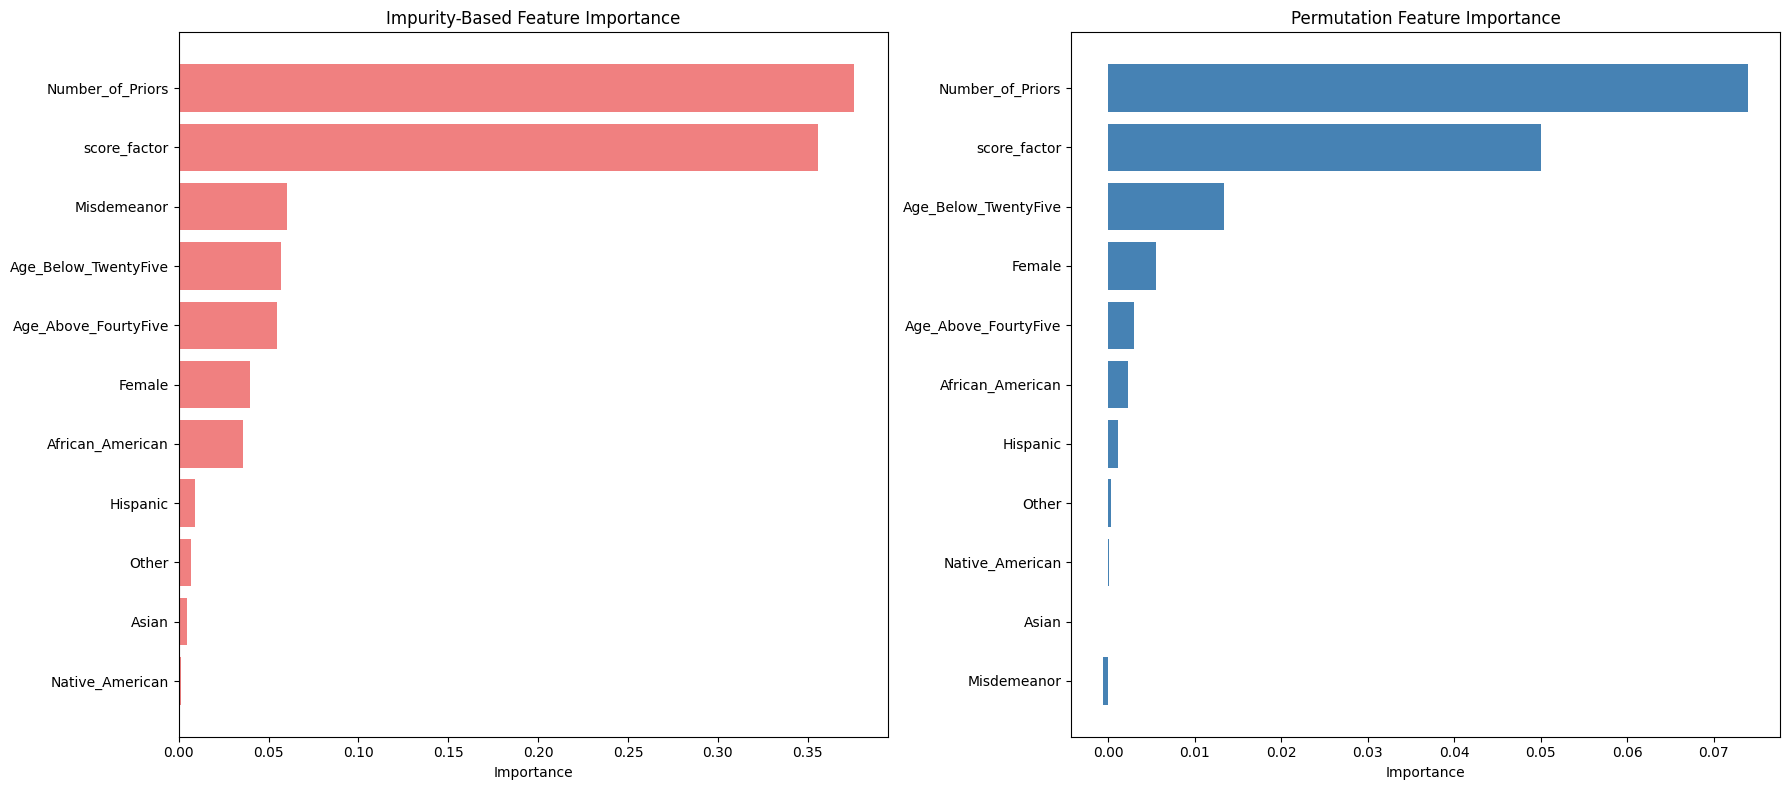

In [38]:
# pair each feature name with its importance and sort them in descending order
features = X_test.columns

impurity_feature_importance = sorted(zip(impurity_importances, features), reverse=True)
sorted_impurity_importances = [value[0] for value in impurity_feature_importance]
sorted_impurity_features = [value[1] for value in impurity_feature_importance]

permutation_indices = np.argsort(permutation_importances)[::-1]
sorted_permutation_importances = permutation_importances[permutation_indices]
sorted_permutation_features = [features[i] for i in permutation_indices]

#cCreate a side-by-side plot for impurity-based and permutation importances
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# plot impurity-based feature importances
axes[0].barh(sorted_impurity_features, sorted_impurity_importances, color='lightcoral')
axes[0].set_title('Impurity-Based Feature Importance')
axes[0].set_xlabel('Importance')
axes[0].invert_yaxis()  # highest importance at the top

# plot permutation feature importances
axes[1].barh(sorted_permutation_features, sorted_permutation_importances, color='steelblue')
axes[1].set_title('Permutation Feature Importance')
axes[1].set_xlabel('Importance')
axes[1].invert_yaxis()  # highest importance at the top

# adjust layout 
plt.tight_layout()
plt.show()

How do you interpret the plots above? What can you learn about how the `RandomForestClassifier` makes predictions? Are there any differences between the impurity-based vs. permutation feature importances? Does it look like the model is discriminating based on any sensitive attribute? Or, does it look like the model is mostly influenced by legitimate attributes? Discuss with a classmate.

____

### Part 2: Performing a fairness assessment

We've built our classifier, evaluated its predictive accuracy, and calculated feature importance to enhance interpretability. 

But remember what we're predicting and the intended use case.In practice, our model could be used to decide whether or not a human being is imprisoned. This is a high-stakes scenario. 

We also know, from domain knowledge, that the U.S. judicial system has a history of racial bias.  "African Americans are more likely than white Americans to be arrested; once arrested, they are more likely to be convicted; and once convicted, and they are more likely to experience lengthy prison sentences. African-American adults are 5.9 times as likely to be incarcerated than whites" ([The Sentencing Project](https://www.sentencingproject.org/reports/report-to-the-united-nations-on-racial-disparities-in-the-u-s-criminal-justice-system/)).

With this in mind, let's perform a fairness assessment. Use the code below to create a `MetricFrame` with `fairlearn` to inspect the `selection_rate`, `true_positive_rate`, and `false_positive_rate` for `African_American` defendants vs. other defendants (i.e., our "sensitive feature" is `African_American`).

In [39]:
# create a MetricFrame to compute metrics across groups
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=y_pred,
    sensitive_features=X_test['African_American'])

# print the results
print(metrics.by_group)

                  selection_rate       TPR       FPR
African_American                                    
0                       0.229730  0.416667  0.118534
1                       0.500623  0.657277  0.323607


# <font color='red'>TASK 4</font>

How do you interpret the output above?

Continuing on with our assessment, use the code below to inspect `demographic_parity_difference` across the `African_American` attribute. The demographic parity difference is defined as the difference between the largest and the smallest group-level selection rate, across all values of the sensitive feature(s). A demographic parity difference of 0 means that all groups have the same selection rate. 

In [40]:
# compute the demographic parity difference
dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test["African_American"])
print(f"Demographic Parity Difference: {dpd:.2f}")

Demographic Parity Difference: 0.27


What does the above output suggest? How does it relate to the `MetricFrame` you printed before?

The demographic parity difference shows us the difference in `selection_rate` across groups based on our sensitive feature. The above doesn't look good. But looking at selection rates alone is just one view of unfairness.

# <font color='red'>TASK 5</font>

Calculate and print the `equalized_odds_difference` below. What does it tell you?

In [41]:
# your code here -  compute and print the equalized odds difference
eod = equalized_odds_difference(y_test, y_pred, sensitive_features=X_test["African_American"])
print(f"Equalized Odds Difference: {eod:.2f}")

Equalized Odds Difference: 0.24


____

### Part 3: Mitgating unfairness

Our assessment above suggests our classifier is making unfair predictions. The classifier is more likely to label African American defendants as recidivism risks and makes more inaccurate predictions (per the TPR and FPR) for African American defendants, as compared to other defendants.

There are several techniques for mitigating unfairness, such as removing correlations between your sensitive feature and other non-sensitive features in preprocessing, or imposing fairness constraints in model training/optimization. Check out the `fairlearn` documentation [here](https://fairlearn.org/v0.9/user_guide/mitigation/index.html) to learn more and see if there's a specific technique that suits your course project. 

For the purpose of the binary classification task in this exercise, we'll apply a postprocessing mitigation technique called *threshold optimization*. We'll keep our tuned classifier as is, rather than returning to data preprocessing or model training/optimization. Instead, what we'll do is apply the `ThreshholdOptimizer` from `fairlearn` to identify the classification threshold that satisfies our desired fairness metric.

Use the code below to apply the `ThreshholdOptimizer` to identify the threshold that satisfies equality of odds, and then re-predict class labels based on that threshold.

In [42]:
# define the equalized odds post-processor
postprocessor = ThresholdOptimizer(
    estimator=best_rf,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

# fit the post-processor
postprocessor.fit(X_test, y_test, sensitive_features=X_test['African_American'])

# predict using the mitigated model
y_pred_mitigated = postprocessor.predict(X_test, sensitive_features=X_test['African_American'])

# <font color='red'>TASK 6</font>

Re-calculate and print the `equalized_odds_difference` below just like you did in Task 3, but with the mitgated predictions this time. Then re-calculate the `MetricFrame` you inspected at the start of Part 2 in this notebook, but with the mitgated predictions this time. 

Did the threshold optimization mitgate unfairness?

In [43]:
# your code here -  re-assess the equality of odds
eod_mitigated = equalized_odds_difference(y_test, y_pred_mitigated, sensitive_features=X_test["African_American"])
print(f"Mitigated Equalized Odds Difference: {eod_mitigated:.2f}")


Mitigated Equalized Odds Difference: 0.01


In [44]:
# your code here - re-assess the metric frame
metrics_mitigated = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=y_pred_mitigated,
    sensitive_features=X_test['African_American'])

# <font color='red'>TASK 7</font>

Finally, re-calculate a classification report with the mitigated predictions to see how your work to ensure fairness in your classifier might have affected standard measures of predictive accuracy.

In [45]:
# your code here - use the postprocessed model to make predictions on the test set
# print the mitigated results
print(metrics_mitigated.by_group)


                  selection_rate       TPR       FPR
African_American                                    
0                       0.283784  0.478261  0.168103
1                       0.346202  0.490610  0.183024


In [46]:

# your code here - print the classification report
print(classification_report(y_test, y_pred_mitigated))

              precision    recall  f1-score   support

           0       0.66      0.83      0.73       841
           1       0.70      0.49      0.57       702

    accuracy                           0.67      1543
   macro avg       0.68      0.66      0.65      1543
weighted avg       0.68      0.67      0.66      1543



------

**That's it for this week! Next time we'll look at what it really means to say "correlation does not imply causation" and the practical limits of using predictive modelling for explanatory tasks.** 